In [1]:
%cd ../py3
import os
wd = os.path.dirname(os.getcwd())
os.environ['PYTHONPATH'] = wd

/mnt/ceph/users/zzhang/pnet_prostate_paper/py3


In [2]:
from config_path import PROSTATE_LOG_PATH, POSTATE_PARAMS_PATH
import config_path
import pandas as pd

import imp
import tensorflow as tf
params_file = './pnet/onsplit_average_reg_10_tanh_large_testing'
log_dir = os.path.join(PROSTATE_LOG_PATH, params_file)
log_dir = log_dir
params_file = os.path.join(POSTATE_PARAMS_PATH, params_file)

In [3]:
from data.data_access import Data
from data.prostate_paper.data_reader import ProstateDataPaper, load_data_type
from data.prostate_paper import data_reader

In [4]:
params_file_full = params_file + '.py'
print(params_file_full)
params = imp.load_source(params_file, params_file_full)

/mnt/ceph/users/zzhang/pnet_prostate_paper/train/params/P1000/./pnet/onsplit_average_reg_10_tanh_large_testing.py


Using TensorFlow backend.


In [5]:
params.data[0]

{'id': 'ALL',
 'type': 'prostate_paper',
 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
  'drop_AR': False,
  'cnv_levels': 3,
  'mut_binary': True,
  'balanced_data': False,
  'combine_type': 'union',
  'use_coding_genes_only': True,
  'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv',
  'training_split': 0}}

In [6]:
data = Data(**params.data[0])

W0403 18:22:21.953238 139856354707264 data_reader.py:64] some genes dont exist in the original data set
W0403 18:22:28.225741 139856354707264 data_reader.py:64] some genes dont exist in the original data set
W0403 18:22:32.841218 139856354707264 data_reader.py:64] some genes dont exist in the original data set


In [7]:
x_train, x_validate_, x_test_, y_train, y_validate_, y_test_, info_train, info_validate_, info_test_, cols = data.get_train_validate_test()

print(x_train.shape)

(807, 27687)


In [8]:
params.data[0]['params']

{'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
 'drop_AR': False,
 'cnv_levels': 3,
 'mut_binary': True,
 'balanced_data': False,
 'combine_type': 'union',
 'use_coding_genes_only': True,
 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv',
 'training_split': 0}

In [9]:
x_list = []
y_list = []
rows_list, cols_list = [], []

In [10]:
# load selected genes
data_path = config_path.DATA_PATH
selected_genes = 'tcga_prostate_expressed_genes_and_cancer_genes.csv'
selected_genes_file = os.path.join(data_path, 'genes')
selected_genes_file = os.path.join(selected_genes_file, selected_genes)
df = pd.read_csv(selected_genes_file, header=0)
selected_genes = list(df['genes'])
print(len(selected_genes))

14665


W0403 18:22:38.588169 139856354707264 data_reader.py:64] some genes dont exist in the original data set


P1000_final_analysis_set_cross_important_only.csv


(1011, 8319)

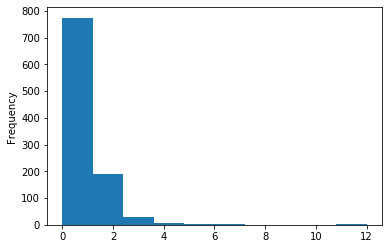

In [11]:
# load mut-binary
print(data_reader.gene_important_mutations_only)
mut_binary = True
x, response, info, genes = data_reader.load_data(data_reader.gene_important_mutations_only, selected_genes)
x.max(axis=1).plot.hist()
if mut_binary:
    #logging.info('mut_binary = True')
    x[x > 1.] = 1.

x_list.append(x), y_list.append(response), rows_list.append(info), cols_list.append(genes)
x.shape

W0403 18:22:40.953042 139856354707264 data_reader.py:64] some genes dont exist in the original data set


2.0
-2.0


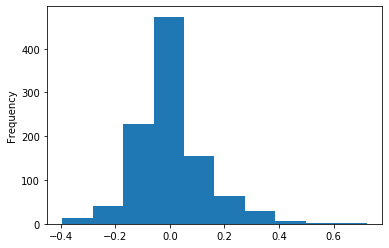

In [12]:
x, response, info, genes = data_reader.load_data(data_reader.cnv_filename, selected_genes)
# raw CNV has been normalized by substracting 2, capped at [-2,2]
print(x.max().max())
print(x.min().min())
x.mean(axis=1).plot.hist()

In [13]:
# load cnv deletion
print(data_reader.cnv_filename)
cnv_levels = 3
cnv_filter_single_event = True   # single event = single-copy deletion or single-copy amplication
x, response, info, genes = data_reader.load_data(data_reader.cnv_filename, selected_genes)
x[x >= 0.0] = 0.
if cnv_levels == 3:
    if cnv_filter_single_event:
        x[x == -1.] = 0.0
        x[x == -2.] = 1.0
    else:
        x[x < 0.0] = 1.0
else:  # cnv == 5 , use everything
    x[x == -1.] = 0.5
    x[x == -2.] = 1.0

x_list.append(x), y_list.append(response), rows_list.append(info), cols_list.append(genes)
x.shape

P1000_data_CNA_paper.csv


W0403 18:22:41.235176 139856354707264 data_reader.py:64] some genes dont exist in the original data set


(1013, 6344)

In [14]:
# load cnv amplification
print(data_reader.cnv_filename)
cnv_levels = 3
cnv_filter_single_event = True   # single event = single-copy deletion or single-copy amplication

x, response, info, genes = data_reader.load_data(data_reader.cnv_filename, selected_genes)
x[x <= 0.0] = 0.
if cnv_levels == 3:
    if cnv_filter_single_event:
        x[x == 1.0] = 0.0
        x[x == 2.0] = 1.0
    else:
        x[x > 0.0] = 1.0
else:  # cnv == 5 , use everything
    x[x == 1.] = 0.5
    x[x == 2.] = 1.0

x_list.append(x), y_list.append(response), rows_list.append(info), cols_list.append(genes)
x.shape

W0403 18:22:45.714950 139856354707264 data_reader.py:64] some genes dont exist in the original data set


P1000_data_CNA_paper.csv


(1013, 6344)

In [15]:
# complete_features: make sure all the data_types have the same set of features_processing (genes)
def combine(x_list, y_list, rows_list, cols_list, data_type_list, combine_type, use_coding_genes_only=False):
    cols_list_set = [set(list(c)) for c in cols_list]

    if combine_type == 'intersection':
        cols = set.intersection(*cols_list_set)
    else:
        cols = set.union(*cols_list_set)
    print("step 1 union of gene features", len(cols))

    if use_coding_genes_only:
        f = os.path.join(data_path, 'genes/HUGO_genes/protein-coding_gene_with_coordinate_minimal.txt')
        coding_genes_df = pd.read_csv(f, sep='\t', header=None)
        coding_genes_df.columns = ['chr', 'start', 'end', 'name']
        coding_genes = set(coding_genes_df['name'].unique())
        cols = cols.intersection(coding_genes)
        print("step 2 intersect w/ coding", len(coding_genes), '; coding AND in cols', len(cols))

    # the unique (super) set of genes
    all_cols = list(cols)

    all_cols_df = pd.DataFrame(index=all_cols)

    df_list = []
    for x, y, r, c, d in zip(x_list, y_list, rows_list, cols_list, data_type_list):
        df = pd.DataFrame(x, columns=c, index=r)
        df = df.T.join(all_cols_df, how='right')
        df = df.T
        print("step 3 fill NA-%s num NAs=" % d, df.isna().sum().sum())
        # IMPORTANT: using features in union will be filled zeros!!
        df = df.fillna(0)
        df_list.append(df)

    all_data = pd.concat(df_list, keys=data_type_list, join='inner', axis=1, )

    # put genes on the first level and then the data type
    all_data = all_data.swaplevel(i=0, j=1, axis=1)

    # order the columns based on genes
    order = all_data.columns.levels[0]
    all_data = all_data.reindex(columns=order, level=0)

    x = all_data.values
    
    
    # NOTE: only the last y is used; all else are discarded
    reordering_df = pd.DataFrame(index=all_data.index)
    y = reordering_df.join(y, how='left')

    y = y.values
    cols = all_data.columns
    rows = all_data.index
    print(
        'After combining, loaded data %d samples, %d variables, %d responses ' % (x.shape[0], x.shape[1], y.shape[0]))

    return all_data, x, y, rows, cols

In [16]:
all_data, x, y, rows, cols = combine(x_list, y_list, rows_list, cols_list, 
                           data_type_list=['mut_important', 'cnv_del', 'cnv_amp'], 
                           combine_type='union', use_coding_genes_only=True)

step 1 union of gene features 9809
step 2 intersect w/ coding 19045 ; coding AND in cols 9229
step 3 fill NA-mut_important num NAs= 1093902
step 3 fill NA-cnv_del num NAs= 3443187
step 3 fill NA-cnv_amp num NAs= 3443187
After combining, loaded data 1011 samples, 27687 variables, 1011 responses 


In [17]:
all_data.head()

CKMT2                       PPP1R26                  \
               mut_important cnv_del cnv_amp mut_important cnv_del cnv_amp   
00-029N9_LN              0.0     0.0     0.0           0.0     0.0     0.0   
01-087MM_BONE            0.0     0.0     0.0           0.0     0.0     0.0   
01-095N1_LN              0.0     0.0     0.0           0.0     0.0     0.0   
01-120A1_LIVER           0.0     0.0     0.0           0.0     0.0     0.0   
02-083E1_LN              0.0     0.0     0.0           0.0     0.0     0.0   

                      ZCCHC6                          TCN2  ...    RHOU  \
               mut_important cnv_del cnv_amp mut_important  ... cnv_amp   
00-029N9_LN              0.0     0.0     0.0           0.0  ...     0.0   
01-087MM_BONE            0.0     0.0     0.0           0.0  ...     0.0   
01-095N1_LN              0.0     0.0     0.0           0.0  ...     0.0   
01-120A1_LIVER           0.0     0.0     0.0           0.0  ...     0.0   
02-083E1_LN              0.0     0.0     0.0           0.0  ...     0.0   

                        ACP1                          WDR7                  \
               mut_important cnv_del cnv_amp mut_important cnv_del cnv_amp   
00-029N9_LN              0.0     0.0     0.0           0.0     0.0     0.0   
01-087MM_BONE            0.0     0.0     0.0           0.0     0.0     0.0   
01-095N1_LN              0.0     0.0     0.0           0.0     0.0     0.0   
01-120A1_LIVER           0.0     0.0     0.0           0.0     0.0     0.0   
02-083E1_LN              0.0     0.0     0.0           1.0     0.0     0.0   

                        EMG1                  
               mut_important cnv_del cnv_amp  
00-029N9_LN              0.0     0.0     0.0  
01-087MM_BONE            0.0     0.0     0.0  
01-095N1_LN              0.0     0.0     0.0  
01-120A1_LIVER           0.0     0.0     0.0  
02-083E1_LN              0.0     0.0     0.0  

[5 rows x 27687 columns]